# beomi/KcELECTRA-base

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5274656770775562694
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 82444615680
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12169920593960793228
physical_device_desc: "device: 0, name: NVIDIA H100 80GB HBM3, pci bus id: 0000:00:05.0, compute capability: 9.0"
xla_global_id: 416903419
]


In [2]:
import re
import torch
import pandas as pd

# GPU 설정
# 없을 시 CPU
# CPU로 뜨지만, GPU 잘만 돌아감
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device:", device)

device: cuda:0


In [3]:
# 엑셀 파일에서 데이터프레임 읽기
df = pd.read_excel(r"C:\Users\administrator\Desktop\X_filter\AI_Model\dataset\sentence_data(cp).xlsx")

print(df.shape)
df.head()

(214189, 2)


,Sentence,label
0,좌배 까는건 ㅇㅂ,1
1,개소리야 니가 빨갱이를 옹호하고 드루킹을 ㅇㅇ짓이라고 말못해서 삐진거야 빨갱아,1
2,애새끼가 초딩도 아니고 ㅋㅋㅋㅋ,1
3,731부대의 후예라 그런지 가학적인 아이디어는 세계최고임 이래서 애교만 떨어도 돈 ...,1
4,재앙이한건햇노,1


In [4]:
null_idx = df[df.label.isnull()].index                             # 해당 index에 null 값 확인
df.loc[null_idx, "Sentence"]                                       # null 값이 존재한 인덱스의 content 값 불러오기

# lable은 content의 가장 끝 문장열로 설정
df.loc[null_idx, "label"] = df.loc[null_idx, "Sentence"].apply(lambda x: x[-1])

# content는 "\t" 앞부분까지의 문자열로 설정
df.loc[null_idx, "Sentence"] = df.loc[null_idx, "Sentence"].apply(lambda x: x[-2])

In [5]:
train_data = df.sample(frac=0.8, random_state=42)                 # train(80%), test(20%) 셋 구분 
test_data = df.drop(train_data.index)                             # 랜덤으로 샘플링(랜덤으로 숫자 배치)

# 데이터셋 갯수 확인
print('중복 제거 전 학습 데이터셋 : {}'.format(len(train_data)))
print('중복 제거 전 테스트 데이터셋 : {}'.format(len(test_data)))

# 중복 데이터 제거
train_data.drop_duplicates(subset=["Sentence"], inplace=True)
test_data.drop_duplicates(subset=["Sentence"], inplace=True)

# 데이터셋 갯수 확인
print('중복 제거 후 학습 데이터셋 : {}'.format(len(train_data)))
print('중복 제거 후 테스트 데이터셋 : {}'.format(len(test_data)))

중복 제거 전 학습 데이터셋 : 171351
중복 제거 전 테스트 데이터셋 : 42838
중복 제거 후 학습 데이터셋 : 167709
중복 제거 후 테스트 데이터셋 : 42587


In [6]:
from transformers import ElectraTokenizer, ElectraForSequenceClassification, TFElectraForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch

# KcELECTRA 모델 및 토크나이저 로드
Kc_model = "beomi/KcELECTRA-base"
Kc_tokenizer = AutoTokenizer.from_pretrained(Kc_model)

c:\Users\administrator\anaconda3\envs\Kc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
train_data

,Sentence,label
146620,어후 나는 내 몸 하나 건사하기 힘들다 키키,0
205991,어른들이니까 고기가 좋지 않을까?,0
146625,친구들이랑 같이 자취하는데 넘 귀엽더라 ㅠ,0
89212,"MBC ''좌빠''' 언론에다, ''라도''' 편향성 방송 제발 징계주어 나라망신 ...",1
57038,''시발''' 우리나라에는 한국사람들만 살게하고 #@이름# 동남아 ''짱깨''' '...,1
...,...,...
5887,2580 또 감성팔이했네 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,1
188969,뭔가 민망한 상황에서 당당하다고 해야 하나 키키,0
46252,Nc가 집행검이벤트 한후 ''폭망하'''는중인데. ㅉㅉ 그리고. 다음의상은. 란제리좀부탁,1
28357,북한이랑 비슷하네 아님 북한이 더할수도멀리있지않다 우리옆에도 있는데 시한폭탄 북한 ...,1


In [8]:
tokenized_train_sentences = Kc_tokenizer( 
    list(train_data["Sentence"]),           # train_data 리스트화
    return_tensors="pt",                    # pytorch의 tensor 형태로 변환
    max_length=128,                         # 최대 토큰길이 설정
    padding=True,                           # 학습 시 빈 값을 0으로 대체
    truncation=True,                        # 초과 토큰 제거
    add_special_tokens=True                 # 추가 토큰 설정
)

In [9]:
tokenized_test_sentences = Kc_tokenizer(
    list(test_data["Sentence"]),           # test_data 리스트화
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

In [10]:
"""
CLS(분류 토큰)   : 시작을 알릴 때 사용
SEP(구분자 토큰) : 서로 다를 때 구분할 사용할 토큰
MASK            : 특정 토큰이 마스크화, 모델이 예측하도록 훈련
PAD             : 일관된 길이로 동일하게 만듦
                                                            """

'\nCLS(분류 토큰)   : 시작을 알릴 때 사용\nSEP(구분자 토큰) : 서로 다를 때 구분할 사용할 토큰\nMASK            : 특정 토큰이 마스크화, 모델이 예측하도록 훈련\nPAD             : 일관된 길이로 동일하게 만듦\n                                                            '

In [11]:
print(tokenized_train_sentences[0])        # 0번째 문장에 해당하는 객체
print("="*200) 
print(tokenized_train_sentences[0].tokens) # 0번째 문장에 토큰의 목록
print("="*200)
print(tokenized_train_sentences[0].ids)    # 0번째 문장에 대한 고유 ID

Encoding(num_tokens=128, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['Ġìĸ´íĽĦ', 'ĠëĤĺëĬĶ', 'ĠëĤ´', 'Ġëª¸', 'ĠíķĺëĤĺ', 'Ġê±´', 'ìĤ¬', 'íķĺê¸°', 'Ġíŀĺëĵ¤ëĭ¤', 'ĠíĤ¤', 'íĤ¤', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[

In [12]:
class CurseDataset(torch.utils.data.Dataset):                                        # 학습을 위한 데이터셋 만들기     
    def __init__(self, encoding, labels):                                            # pytorch에서 학습할 수 있게 데이터셋 생성
        self.encodings = encoding                                                    # Feature Data / 'Sentence'
        self.labels = labels                                                         # Target Data / 'Label'
    
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} # self.encodings 딕셔너리 내의 값 중에 val를 torch.tensor로 변환해 하여
        item["labels"] = torch.tensor(self.labels[idx])                             # key: toch.tensor(val[ix])라는 item 딕셔너리 형성
        return item                                                                 # 새로운 labels 키 값에 value torch.tensor(self.labels[idx]) 쌍을 생성
    
    def __len__(self):
        return len(self.labels)                                                     # self.labels 길이 반환

In [13]:
# train_set, test_set에 대한 데이터셋을 각각 생성
train_label = train_data["label"].values
test_label = test_data["label"].values

train_dataset = CurseDataset(tokenized_train_sentences, train_label)
test_dataset = CurseDataset(tokenized_test_sentences, test_label)

In [14]:
Kc_model = AutoModelForSequenceClassification.from_pretrained(Kc_model, num_labels=2)   # 사전 학습된 모델 찾아오기
Kc_model.to(device)                                                                     # num_labels 평가지표 확인

Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.de

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=3)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [15]:
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import Trainer, TrainingArguments

# Define the initial TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=64,
    logging_dir='./logs',
    logging_steps=500,
    save_total_limit=2,
)

# 학습과정에서 사용할 평가지표를 위한 함수 설정
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # 다중 클래스 분류의 경우 아래처럼 수정
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    # 정확도 구하기
    acc = accuracy_score(labels, preds)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }



# Define a range of batch sizes to try
batch_sizes_to_try = [2, 4, 8, 16, 32, 64, 128, 256]

# Create a grid of hyperparameters to search
param_grid = {
    'per_device_train_batch_size': batch_sizes_to_try,
}

# Generate all combinations of hyperparameters
param_combinations = list(ParameterGrid(param_grid))

# Results list for storing metrics
results_list = []

# Iterate over each combination of hyperparameters
for params in param_combinations:
    # Update the batch size in the training arguments
    training_args.per_device_train_batch_size = params['per_device_train_batch_size']
    
    # Create a new Trainer with updated batch size
    trainer = Trainer(
        model=Kc_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )
    
    # Train the model
    trainer.train()
    
    # Evaluate and store the metrics
    metrics = trainer.evaluate()
    results_dict = {
        'batch_size': params['per_device_train_batch_size'],
        'metrics': metrics,
    }
    results_list.append(results_dict)



 76%|███████▌  | 500/656 [03:50<01:11,  2.17it/s]

{'loss': 0.4448, 'learning_rate': 1.1890243902439025e-05, 'epoch': 0.76}


C:\Users\administrator\AppData\Local\Temp\2\ipykernel_624\1869798269.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} # self.encodings 딕셔너리 내의 값 중에 val를 torch.tensor로 변환해 하여
100%|██████████| 656/656 [05:04<00:00,  2.15it/s]


{'train_runtime': 304.783, 'train_samples_per_second': 550.257, 'train_steps_per_second': 2.152, 'train_loss': 0.44456370283917684, 'epoch': 1.0}


100%|█████████▉| 664/666 [00:30<00:00, 21.85it/s]c:\Users\administrator\anaconda3\envs\Kc\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 666/666 [00:30<00:00, 21.98it/s]


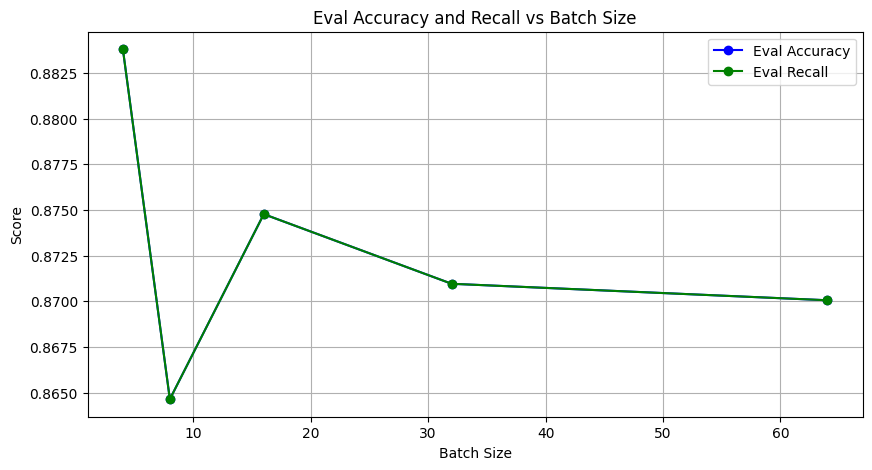

In [16]:
import matplotlib.pyplot as plt

# 주어진 데이터
batch_sizes = [4, 8, 16, 32, 64]
eval_accuracy = [0.8838049367850692, 0.8646397752358017, 0.8747742323901264, 0.8709612683122617, 0.8700581978727674]
eval_recall = [0.8838049367850692, 0.8646397752358017, 0.8747742323901264, 0.8709612683122617, 0.8700581978727674]

# 그래프 그리기
plt.figure(figsize=(10, 5))

# Eval Accuracy 그래프
plt.plot(batch_sizes, eval_accuracy, marker='o', label='Eval Accuracy', color='blue')

# Eval Recall 그래프
plt.plot(batch_sizes, eval_recall, marker='o', label='Eval Recall', color='green')

# 그래프 설정
plt.title('Eval Accuracy and Recall vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# 그래프 보이기
plt.show()


In [17]:
배치 크기: 4, 메트릭: {'eval_loss': 0.40799680352211, 'eval_accuracy': 0.8838049367850692, 'eval_f1': 0.8837942889526615, 'eval_precision': 0.8838708761686718, 'eval_recall': 0.8838049367850692, 'eval_runtime': 7.0443, 'eval_samples_per_second': 1414.765, 'eval_steps_per_second': 22.146, 'epoch': 1.0}

배치 크기: 8, 메트릭: {'eval_loss': 0.34564298391342163, 'eval_accuracy': 0.8646397752358017, 'eval_f1': 0.8643090477038273, 'eval_precision': 0.8687827109620981, 'eval_recall': 0.8646397752358017, 'eval_runtime': 7.0755, 'eval_samples_per_second': 1408.521, 'eval_steps_per_second': 22.048, 'epoch': 1.0}

배치 크기: 16, 메트릭: {'eval_loss': 0.33332547545433044, 'eval_accuracy': 0.8747742323901264, 'eval_f1': 0.874774862814322, 'eval_precision': 0.874777254761814, 'eval_recall': 0.8747742323901264, 'eval_runtime': 7.0825, 'eval_samples_per_second': 1407.128, 'eval_steps_per_second': 22.026, 'epoch': 1.0}

배치 크기: 32, 메트릭: {'eval_loss': 0.35686635971069336, 'eval_accuracy': 0.8709612683122617, 'eval_f1': 0.8709583632658499, 'eval_precision': 0.8710851870502736, 'eval_recall': 0.8709612683122617, 'eval_runtime': 7.0757, 'eval_samples_per_second': 1408.481, 'eval_steps_per_second': 22.047, 'epoch': 1.0}

배치 크기: 64, 메트릭: {'eval_loss': 0.34407153725624084, 'eval_accuracy': 0.8700581978727674, 'eval_f1': 0.8700228815082413, 'eval_precision': 0.8706682011245421, 'eval_recall': 0.8700581978727674, 'eval_runtime': 7.0775, 'eval_samples_per_second': 1408.116, 'eval_steps_per_second': 22.042, 'epoch': 1.0}


SyntaxError: invalid syntax (1214336881.py, line 1)

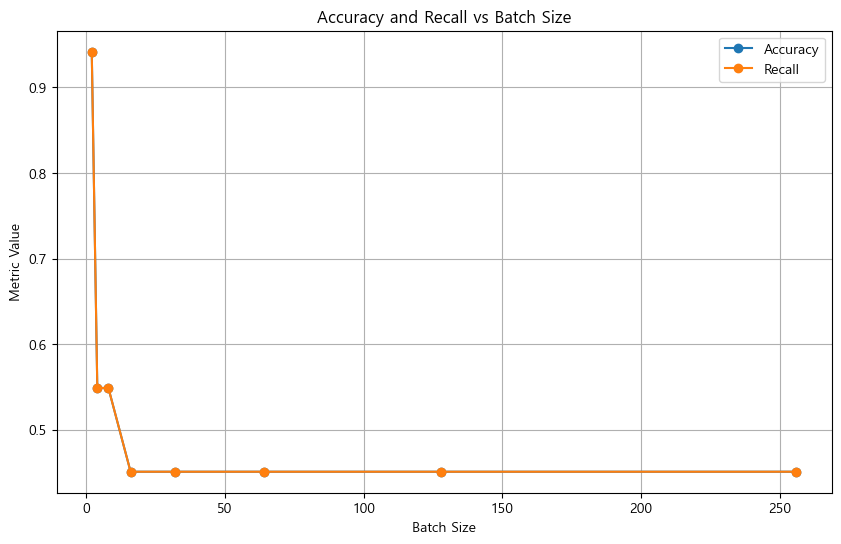

In [19]:
import matplotlib.pyplot as plt

# 주어진 데이터
batch_sizes = [2, 4, 8, 16, 32, 64, 128, 256]
accuracies = [0.941766266701106, 0.5489468617183647, 0.5489468617183647, 0.45105313828163524, 0.45105313828163524, 0.45105313828163524, 0.45105313828163524, 0.45105313828163524]
recalls = [0.941766266701106, 0.5489468617183647, 0.5489468617183647, 0.45105313828163524, 0.45105313828163524, 0.45105313828163524, 0.45105313828163524, 0.45105313828163524]

# 그래프 그리기
plt.figure(figsize=(10, 6))

plt.plot(batch_sizes, accuracies, marker='o', label='Accuracy')
plt.plot(batch_sizes, recalls, marker='o', label='Recall')

plt.title('Accuracy and Recall vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)
plt.show()


배치 크기: 2, 메트릭: {'eval_loss': 0.2695576548576355, 'eval_accuracy': 0.941766266701106, 'eval_f1': 0.941874847524921, 'eval_precision': 0.9432284099734813, 'eval_recall': 0.941766266701106, 'eval_runtime': 30.2647, 'eval_samples_per_second': 1407.15, 'eval_steps_per_second': 22.006, 'epoch': 1.0}
정확도: 0.941766266701106
재현율: 0.941766266701106
배치 크기: 4, 메트릭: {'eval_loss': 2.563800573348999, 'eval_accuracy': 0.5489468617183647, 'eval_f1': 0.389093602160295, 'eval_precision': 0.30134265699044144, 'eval_recall': 0.5489468617183647, 'eval_runtime': 30.1013, 'eval_samples_per_second': 1414.789, 'eval_steps_per_second': 22.125, 'epoch': 1.0}
정확도: 0.5489468617183647
재현율: 0.5489468617183647
배치 크기: 8, 메트릭: {'eval_loss': 0.7014555335044861, 'eval_accuracy': 0.5489468617183647, 'eval_f1': 0.389093602160295, 'eval_precision': 0.30134265699044144, 'eval_recall': 0.5489468617183647, 'eval_runtime': 30.12, 'eval_samples_per_second': 1413.911, 'eval_steps_per_second': 22.112, 'epoch': 1.0}
정확도: 0.548946861

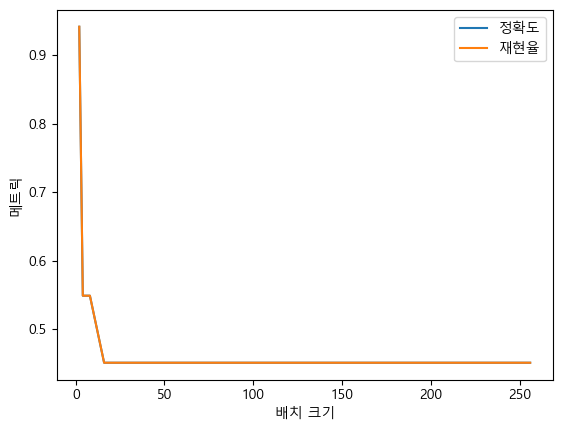

In [18]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import Trainer, TrainingArguments

# 폰트 설정 (한글 폰트 사용을 위해)
font_path = "C:/Windows/Fonts/malgun.ttf"  # 한글 폰트 경로에 맞게 수정
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 코드 계속...

# 결과 및 사용 가능한 키 출력
# 'metrics' 딕셔너리에서 사용 가능한 키 출력
for result in results_list:
    print(f"배치 크기: {result['batch_size']}, 메트릭: {result['metrics']}")

    # 'accuracy' 값에 액세스
    accuracy_value = result['metrics'].get('eval_accuracy', None)
    recall_value = result['metrics'].get('eval_recall', None)  # 'eval_recall'로 수정
    if accuracy_value is not None:
        print(f"정확도: {accuracy_value}")
    else:
        print("정확도 키를 찾을 수 없습니다.")
    if recall_value is not None:
        print(f"재현율: {recall_value}")
    else:
        print("재현율 키를 찾을 수 없습니다.")

# 그래프에 포함할 메트릭 키 선택
metric_key = 'eval_accuracy'

# 결과 그래프 그리기
plt.plot([result['batch_size'] for result in results_list], [result['metrics'][metric_key] for result in results_list], label='정확도')
plt.plot([result['batch_size'] for result in results_list], [result['metrics']['eval_recall'] for result in results_list], label='재현율')

# 'precision' 키가 있는지 확인하고, 있으면 플로팅
if all('precision' in result['metrics'] for result in results_list):
    plt.plot([result['batch_size'] for result in results_list], [result['metrics']['precision'] for result in results_list], label='정밀도')
else:
    print("메트릭스에서 'precision' 키를 찾을 수 없습니다.")

# 'f1' 키가 있는지 확인하고, 있으면 플로팅
if all('f1' in result['metrics'] for result in results_list):
    plt.plot([result['batch_size'] for result in results_list], [result['metrics']['f1'] for result in results_list], label='F1 점수')
else:
    print("메트릭스에서 'f1' 키를 찾을 수 없습니다.")

plt.xlabel('배치 크기')
plt.ylabel('메트릭')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import Trainer, TrainingArguments

# 폰트 설정 (한글 폰트 사용을 위해)
font_path = "C:/Windows/Fonts/malgun.ttf"  # 한글 폰트 경로에 맞게 수정
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 코드 계속...

# 결과 및 사용 가능한 키 출력
# 'metrics' 딕셔너리에서 사용 가능한 키 출력
for result in results_list:
    print(f"배치 크기: {result['batch_size']}, 메트릭: {result['metrics']}")

    # 'accuracy' 값에 액세스
    accuracy_value = result['metrics'].get('eval_accuracy', None)
    recall_value = result['metrics'].get('eval_recall', None)  # 'eval_recall'로 수정
    if accuracy_value is not None:
        print(f"정확도: {accuracy_value}")
    else:
        print("정확도 키를 찾을 수 없습니다.")
    if recall_value is not None:
        print(f"재현율: {recall_value}")
    else:
        print("재현율 키를 찾을 수 없습니다.")

# 그래프에 포함할 메트릭 키 선택
metric_key = 'eval_accuracy'

# 결과 그래프 그리기
plt.plot([result['batch_size'] for result in results_list], [result['metrics'][metric_key] for result in results_list], label='정확도')
plt.plot([result['batch_size'] for result in results_list], [result['metrics']['eval_recall'] for result in results_list], label='재현율')

# 'precision' 키가 있는지 확인하고, 있으면 플로팅
if all('precision' in result['metrics'] for result in results_list):
    plt.plot([result['batch_size'] for result in results_list], [result['metrics']['precision'] for result in results_list], label='정밀도')
else:
    print("메트릭스에서 'precision' 키를 찾을 수 없습니다.")

# 'f1' 키가 있는지 확인하고, 있으면 플로팅
if all('f1' in result['metrics'] for result in results_list):
    plt.plot([result['batch_size'] for result in results_list], [result['metrics']['f1'] for result in results_list], label='F1 점수')
else:
    print("메트릭스에서 'f1' 키를 찾을 수 없습니다.")

plt.xlabel('배치 크기')
plt.ylabel('메트릭')
plt.legend()
plt.show()


In [ ]:
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score


In [ ]:
# Define the initial TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=64,
    logging_dir='./logs',
    logging_steps=500,
    save_total_limit=2,
)

In [ ]:
# 학습과정에서 사용할 평가지표를 위한 함수 설정
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # 정밀도, 재현율, f1 구하기 
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
  # 정확도 구하기
  acc = accuracy_score(labels, preds)
  return{
      'accuracy': acc,
      'f1': f1,
      'precision': precision,
      'recall': recall
  }

In [ ]:
# Define a range of batch sizes to try
batch_sizes_to_try = [4, 8, 16, 32, 64]

# Create a grid of hyperparameters to search
param_grid = {
    'per_device_train_batch_size': batch_sizes_to_try,
}


In [ ]:
# Generate all combinations of hyperparameters
param_combinations = list(ParameterGrid(param_grid))

# Results list for storing metrics
results_list = []

In [ ]:
# Iterate over each combination of hyperparameters
for params in param_combinations:
    # Update the batch size in the training arguments
    training_args.per_device_train_batch_size = params['per_device_train_batch_size']
    
    # Create a new Trainer with updated batch size
    trainer = Trainer(
        model=Kc_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )

In [ ]:
 # Evaluate and store the metrics
    metrics = trainer.evaluate()
    results_dict = {
        'batch_size': params['per_device_train_batch_size'],
        'metrics': metrics,
    }
    results_list.append(results_dict)

In [ ]:
# Print results
for result in results_list:
    print(f"Batch Size: {result['batch_size']}, Metrics: {result['metrics']}")

# Plotting the results
batch_sizes = [result['batch_size'] for result in results_list]
accuracies = [result['metrics']['accuracy'] for result in results_list]
recalls = [result['metrics']['recall'] for result in results_list]

plt.plot(batch_sizes, accuracies, label='Accuracy')
plt.plot(batch_sizes, recalls, label='Recall')
plt.xlabel('Batch Size')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [ ]:
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Define the initial TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=64,
    logging_dir='./logs',
    logging_steps=500,
    save_total_limit=2,
)


# 학습과정에서 사용할 평가지표를 위한 함수 설정
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # 정밀도, 재현율, f1 구하기 
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
  # 정확도 구하기
  acc = accuracy_score(labels, preds)
  return{
      'accuracy': acc,
      'f1': f1,
      'precision': precision,
      'recall': recall
  }
# Define a range of batch sizes to try
batch_sizes_to_try = [4, 8, 16, 32, 64]

# Create a grid of hyperparameters to search
param_grid = {
    'per_device_train_batch_size': batch_sizes_to_try,
}

# Generate all combinations of hyperparameters
param_combinations = list(ParameterGrid(param_grid))

# Results list for storing metrics
results_list = []

# Iterate over each combination of hyperparameters
for params in param_combinations:
    # Update the batch size in the training arguments
    training_args.per_device_train_batch_size = params['per_device_train_batch_size']
    
    # Create a new Trainer with updated batch size
    trainer = Trainer(
        model=Kc_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )
    
    # Train the model
    trainer.train()
    
    # Evaluate and store the metrics
    metrics = trainer.evaluate()
    results_dict = {
        'batch_size': params['per_device_train_batch_size'],
        'metrics': metrics,
    }
    results_list.append(results_dict)

# Print results
for result in results_list:
    print(f"Batch Size: {result['batch_size']}, Metrics: {result['metrics']}")

# Plotting the results
batch_sizes = [result['batch_size'] for result in results_list]
accuracies = [result['metrics']['accuracy'] for result in results_list]
recalls = [result['metrics']['recall'] for result in results_list]

plt.plot(batch_sizes, accuracies, label='Accuracy')
plt.plot(batch_sizes, recalls, label='Recall')
plt.xlabel('Batch Size')
plt.ylabel('Metrics')
plt.legend()
plt.show()


In [ ]:
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from transformers import Trainer, TrainingArguments

# Define the initial TrainingArguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=64,
    logging_dir='./logs',
    logging_steps=500,
    save_total_limit=2,
)

In [ ]:
# 학습과정에서 사용할 평가지표를 위한 함수 설정
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  # 정밀도, 재현율, f1 구하기 
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
  # 정확도 구하기
  acc = accuracy_score(labels, preds)
  return{
      'accuracy': acc,
      'f1': f1,
      'precision': precision,
      'recall': recall
  }

In [ ]:
# Define a range of batch sizes to try
batch_sizes_to_try = [4, 8, 16, 32, 64]

# Create a grid of hyperparameters to search
param_grid = {
    'per_device_train_batch_size': batch_sizes_to_try,
}

# Generate all combinations of hyperparameters
param_combinations = list(ParameterGrid(param_grid))

# Results list for storing metrics
results_list = []

In [ ]:
# Iterate over each combination of hyperparameters
for params in param_combinations:
    # Update the batch size in the training arguments
    training_args.per_device_train_batch_size = params['per_device_train_batch_size']
    
    # Create a new Trainer with updated batch size
    trainer = Trainer(
        model=Kc_model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
        compute_metrics=compute_metrics,
    )
    
    # Train the model
    trainer.train()
    
    # Evaluate and store the metrics
    metrics = trainer.evaluate()
    results_dict = {
        'batch_size': params['per_device_train_batch_size'],
        'metrics': metrics,
    }
    results_list.append(results_dict)

In [ ]:
for result in results_list:
    print(f"Batch Size: {result['batch_size']}, Metrics: {result['metrics']}")

    # Print available keys in the 'metrics' dictionary
    available_keys = result['metrics'].keys()
    print(f"Available keys: {available_keys}")

# Plotting the results
batch_sizes = [result['batch_size'] for result in results_list]
# Use an available metric key instead of 'accuracy', for example, 'f1'
metric_key = 'f1'  # You can change this to another available metric
metrics_values = [result['metrics'][metric_key] for result in results_list]

plt.plot(batch_sizes, metrics_values, label=metric_key)
plt.xlabel('Batch Size')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [ ]:
def sentence_predict(sent):
    Kc_model.eval()

    Kc_tokenized_sent = Kc_tokenizer(
        text_target=sent,
        return_tensors="pt",
        truncation=True,
        add_special_tokens=True,
        max_length=128
    )

    Kc_tokenized_sent.to(device)

    with torch.no_grad():
        outputs = Kc_model(
        input_ids=Kc_tokenized_sent["input_ids"],
        attention_mask=Kc_tokenized_sent["attention_mask"],
        token_type_ids=Kc_tokenized_sent["token_type_ids"]
    )

    logits = outputs[0]
    logits = logits.detach().cpu()
    result = logits.argmax(-1)
    if result == 0:
        return False, sent
    elif result == 1:
        return True, sent


In [ ]:
print(sentence_predict("화이팅"))
print(sentence_predict("이게 맞아?"))

In [ ]:
# 'RNN_2' 모듈을 가져오기 위한 경로를 sys.path에 추가
import sys
sys.path.append(r'C:\Users\administrator\Desktop\X_filter\Algorithm\RNN')
 
# 'RNN' 모듈을 import
from RNN import *

In [ ]:
def badword_find(sent):
    badword_df = pd.read_excel(r'C:\Users\GJAISCHOOL\Desktop\X_filter\Algorithm\dataset\word_list (완성).xlsx')
    found_bad_word = False  # 입력 문장에 단어가 발견되었는지를 나타내는 플래그
    for idx, row in badword_df.iterrows():
        if row["WORD"] in sent:
            # 'WORD'가 입력 문장에 포함된 경우
            new_word = row["대체어"]
            if not pd.isnull(new_word):
                # RNN_result = sentence_generation(new_word, 2) + " "
                sent = sent.replace(row["WORD"], new_word)
                found_bad_word = True
            else:
                sent = sent.replace(row["WORD"], "*" * len(row["WORD"]))
                found_bad_word = True
    
    if not found_bad_word:
        # result = "@" * len(input_sentence)
        sent = "혐오 표현입니다."
    return sent

# 테스트
input_sentence = "씨발"
speak_result = badword_find(input_sentence)
print(speak_result)

In [ ]:
def speak_pre(sent):
    is_malicious, _ = sentence_predict(sent)
    if not is_malicious:
        return sent
    else:
        return badword_find(sent)

def speak(sent):
    is_malicious, sent_result = sentence_predict(sent)
    if not is_malicious:
        return sent
    else:
        return badword_find(sent_result)

In [ ]:
import re
import kss
from pykospacing import Spacing
from soynlp.normalizer import repeat_normalize

# 띄어쓰기 설정
spacing = Spacing()

In [ ]:
# 특수문자 제거
def cleanse(text):
    pattern = re.compile(r'\s+')
    text = re.sub(pattern, ' ', text)
    text = re.sub('[^가-힣ㄱ-ㅎㅏ|a-zA-Z0-9]','', text)
    return text

In [ ]:
def clean_and_repeat_normalize(text):
    cleansed_text = cleanse(text)                                             # 특수문자 제거
    normalized_text = repeat_normalize(cleansed_text, num_repeats=2)          # 중복문자 제거
    input_data = re.sub(r'\d', '', normalized_text)                           # 제거
    normalized_text = spacing(input_data)                                     # 띄어쓰기 보정 

    return normalized_text

clean_and_repeat_normalize("아버지가방에들어가신다")

In [ ]:
def final_output():
    input_text = clean_and_repeat_normalize(input("텍스트를 입력하세요: "))
    sentences = kss.split_sentences(input_text)

    sentences_list = []
    for sentence in sentences:
        result = speak(sentence)
        sentences_list.append(result) 

    long_test = ' '.join(sentences_list)
    return long_test

In [ ]:
# 시발 정작 지네들 자식은 몸쓰는일 안시킬거면서 개지랄떠네 ㅋㅋㅋ
final_output()

In [ ]:
import subprocess
result_1 = subprocess.run(['pip', 'install', 'tensorflow'], capture_output=True, text=True)   # 필요 라이브러리 설치
result_2 = subprocess.run(['pip', 'show', 'tensorflow'], capture_output=True, text=True)
print(result_1.stdout)
print(result_2.stdout)                                               

import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

df = pd.read_csv(r'C:\Users\GJAISCHOOL\Desktop\sentence pl data1113 수정.csv')

sentences = df['Sentence'].tolist()
rnn_tokenizer = Tokenizer()
rnn_tokenizer.fit_on_texts(sentences)

vocab_size = len(rnn_tokenizer.word_index) + 1                          # 어휘 사전에 크기 계산 

sequences = list()                                                      # 각 문장을 단어 시퀀스로 변환하고, 문장의 부분 시퀀스를 생성하여 리스트에 추가
for line in sentences:
    encoded = rnn_tokenizer.texts_to_sequences([line])[0]               # 현재 문장을 정수로 시퀀스로 변수
    for i in range(1, len(encoded)):                                    # 문장의 부분 시퀀스를 생성하고 리스트에 추가
        sequence = encoded[: i+1]
        sequences.append(sequence)

max_len = max(len(l) for l in sequences)                                # 모든 샘플에서 길이가 가장 긴 샘플의 길이 출력
sequences = pad_sequences(sequences, maxlen=max_len, padding='pre')     # 시퀀스 데이터를 패딩하여 일정한 길이로 만듦 (여기서는 가장 긴 샘플의 길이로 패딩)

sequences = np.array(sequences)                                         # 패딩이 된 시퀀스를 넘파이 배열로 변환
                                                                        # 입력 및 출력 데이터 생성
X = sequences[:, :-1]                                                   # 시퀀스에서 마지막 단어를 제외한 부분은 입력(X)
y = sequences[:, -1]                                                    # 시퀀스에 마지막 단어는 출력
y = to_categorical(y, num_classes=vocab_size)                           # 출력(y)을 one-hot 인코딩 형태로 변환

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN

embedding_dim = 10                                                      # 임베딩 차원을 10으로 10차원의 실수 벡터로 표현
hidden_units = 32                                                       # 순환 신경망 내 내부에서의 뉴련의 수

RNN_model = Sequential()                                                    
RNN_model.add(Embedding(vocab_size, embedding_dim))                     # Embedding 레이어 추가: 어휘 사전의 크기를 입력으로 받고, 지정된 임베딩 차원으로 단어를 임베딩
RNN_model.add(SimpleRNN(hidden_units))                                  # 지정된 은닉 유닛 수를 가진 단순한 RNN 레이어
RNN_model.add(Dense(vocab_size, activation='softmax'))                  # 출력 레이어 추가 : 어휘 사전의 크길르 가진 Dense 레이어를 사용하며, 활성화 함수는 softmax
RNN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
                                                                        # 모델 컴파일: 다중 클래스 분류 문제이므로 categorical_crossentropy 손실 함수와 Adam 옵티마이저 사용
RNN_model.fit(X, y, epochs=20, verbose=2)                               # 모델 학습: 입력(X) 및 출력(y) 데이터를 사용하여 주어진 에폭 동안 모델을 학습

def sentence_generation(current_word, n, temperature=1.0, model=RNN_model, tokenizer=rnn_tokenizer):
    init_word = current_word                                            # 시작 단어와 문장을 저장할 빈 문자열 초기화
    sentence = ''

    for _ in range(n):                                                  # n개 단어 만큼 문자 생성
        encoded = rnn_tokenizer.texts_to_sequences([current_word])[0]   # 현재 단어를 토크나이저를 사용하여 정수 시퀀스로 변환 
                                                                        # ex) "Hello, how are you?" => "Hello"가 1, "how"가 2, "are"가 3, "you"가 4라고 할 때 => [1, 2, 3, 4]
        encoded = pad_sequences([encoded], maxlen=5, padding='pre')     # 시퀀스가 5로 설정하고, 부족하면 앞쪽에 0을 채워넣고 부족하면 앞부분을 자른다.
                                                                        # 만약 뒤쪽으로 바꾸고싶으면 padding='post를 주면 된다.
        result = RNN_model.predict(encoded, verbose=0)                  # 모델의 다음단어 예측
        result = result / temperature                                   # 확률에 온도를 적용하여 랜덤성 조절
        result = np.exp(result) / np.sum(np.exp(result), axis=1)        # 소프트맥스를 적용하여 최종 확률 얻기
        sampled_index = np.random.choice(len(result[0]), p=result[0])   # 예측된 확률을 기반으로 다음 단어 샘플링
        word = rnn_tokenizer.index_word[sampled_index]

        current_word = current_word + ' ' + word                        # 현재 단어와 문장 업데이트
        sentence = sentence + ' ' + word

    sentence = init_word + sentence
    return sentence